In [51]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_hit_angle_histogram(dataframe):
    # Extract the 'angle_from_first_base_line' column from the DataFrame
    angles = dataframe['angle_from_first_base_line']

    # Create a histogram with bins of degree 5
    bins = list(range(0, 91, 5))  # Bins from 0 to 90 with a step of 5
    plt.hist(angles, bins=bins, edgecolor='black')

    # Set plot labels and title
    plt.xlabel('Angle from First Base Line (degrees)')
    plt.ylabel('Frequency')
    plt.title('Hit Angle Distribution')

    # Show the plot
    plt.show()

In [52]:
data = pd.read_csv('./data/final_cleaned_statcast_shift_data.csv')

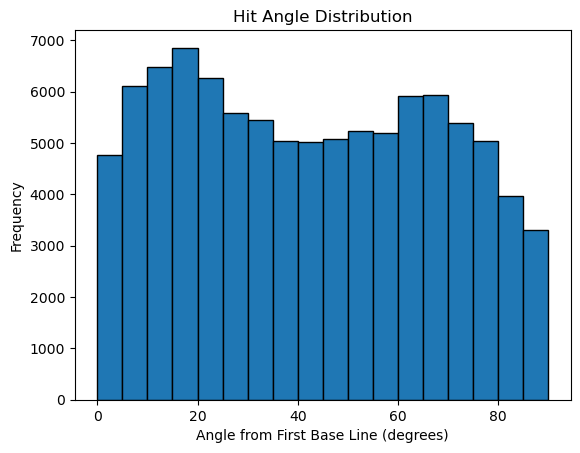

In [53]:
plot_hit_angle_histogram(data)

In [54]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def plot_weighted_hit_angle_histogram(dataframe):
    # Extract 'angle_from_first_base_line' and 'dist' columns from the DataFrame
    angles = dataframe['angle_from_first_base_line']
    distances = dataframe['dist']

    # Min-max scale the 'dist' column to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_distances = scaler.fit_transform(distances.values.reshape(-1, 1))

    # Create a weighted histogram with bins of degree 5
    bins = list(range(0, 91, 5))  # Bins from 0 to 90 with a step of 5
    plt.hist(angles, bins=bins, weights=scaled_distances.flatten(), edgecolor='black')

    # Set plot labels and title
    plt.xlabel('Angle from First Base Line (degrees)')
    plt.ylabel('Weighted Frequency')
    plt.title('Weighted Hit Angle Distribution')

    # Show the plot
    plt.show()

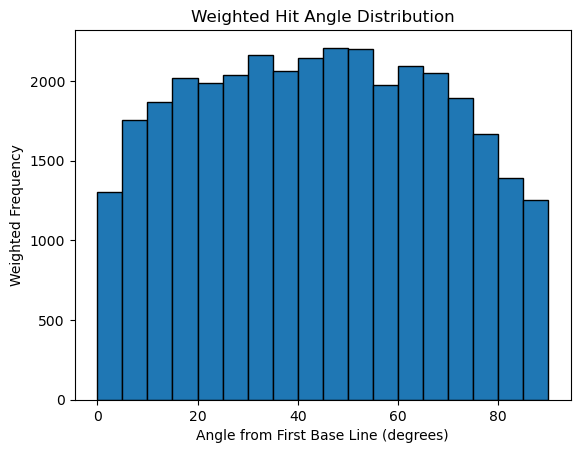

In [55]:
plot_weighted_hit_angle_histogram(data)

In [56]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math

def histogram_poly_fit(dataframe, num_bins=18, degree=3, weighted=True, plot_hist=True):
    # Extract 'angle_from_first_base_line' and 'dist' columns from the DataFrame
    angles = dataframe['angle_from_first_base_line']
    distances = dataframe['dist']

    # Set bins for histogram
    bin_width = math.floor(90 / num_bins)
    bins = list(range(0, 91, bin_width))

    weights = None
    if weighted:
        # Min-max scale the 'dist' column to the range [0, 1]
        scaler = MinMaxScaler()
        scaled_distances = scaler.fit_transform(distances.values.reshape(-1, 1))
        weights = scaled_distances.flatten()

    # Create a histogram with specified bins
    heights, bins, _ = plt.hist(angles, bins=bins, weights=weights, edgecolor='black', alpha=0.7)

    # Calculate bin centers from bin edges
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Fit a polynomial to the data using bin centers
    coefficients = np.polyfit(bin_centers, heights, degree)
    polynomial = np.poly1d(coefficients)

    # Plot the fitted polynomial
    x_range = (bin_centers[0], bin_centers[-1])
    x = np.linspace(x_range[0], x_range[1], 100)
    plt.plot(x, polynomial(x), 'r', linewidth=2)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((heights - polynomial(bin_centers))**2)

    if plot_hist:
        ylabel = 'Frequency'
        title = f'Hit Angle Distribution with Polynomial Fit (Degree {degree})'
        if weighted:
            ylabel = 'Weighted ' + ylabel
            title = 'Weighted ' + title
        # Set plot labels and title and show plot
        plt.xlabel('Angle from First Base Line (degrees)')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.show()
    
    return polynomial, x_range, mse

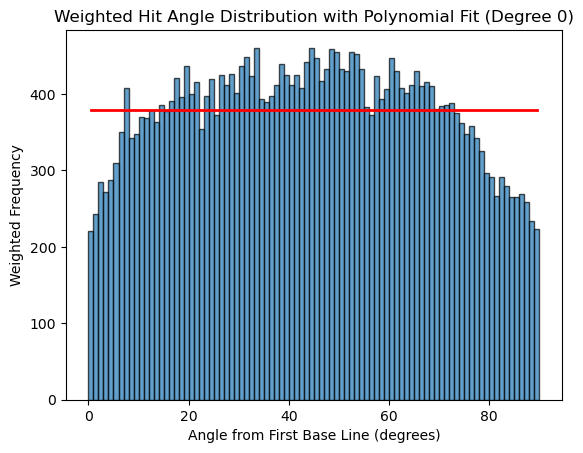

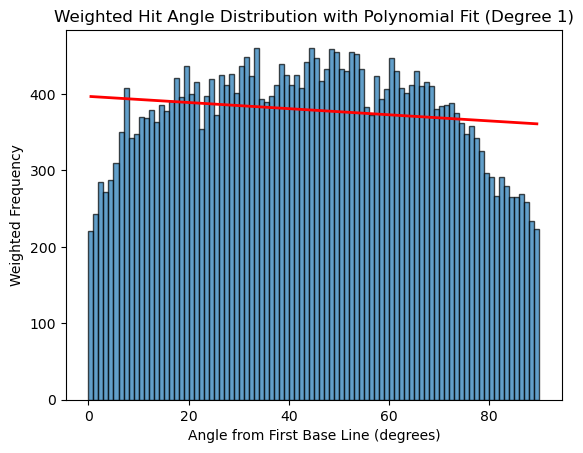

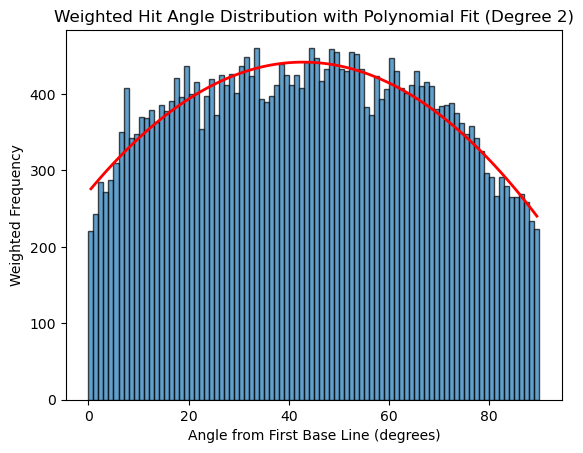

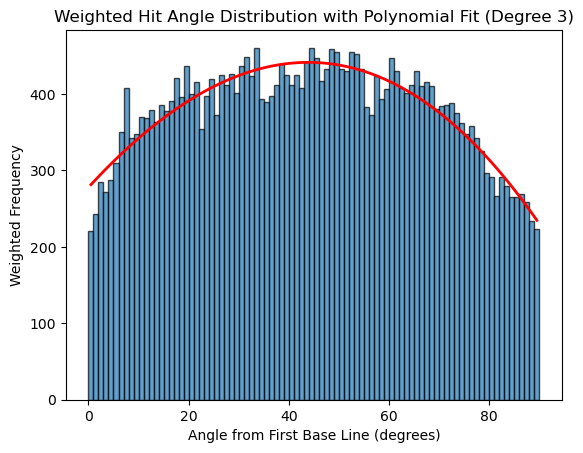

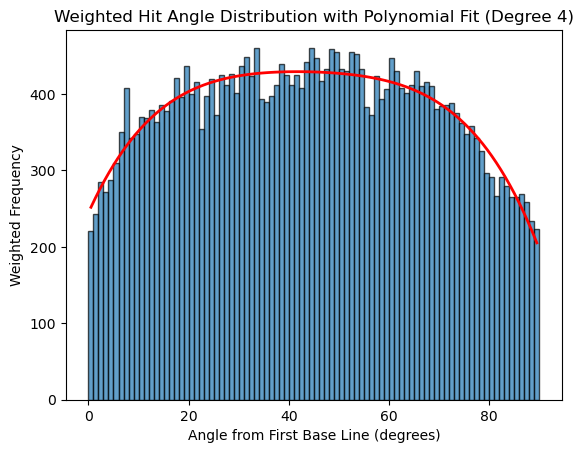

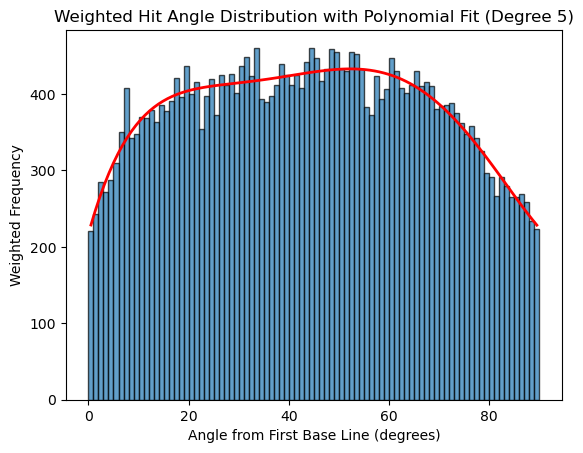

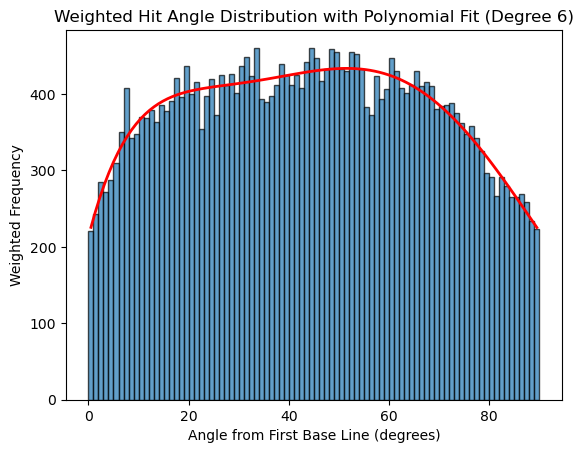

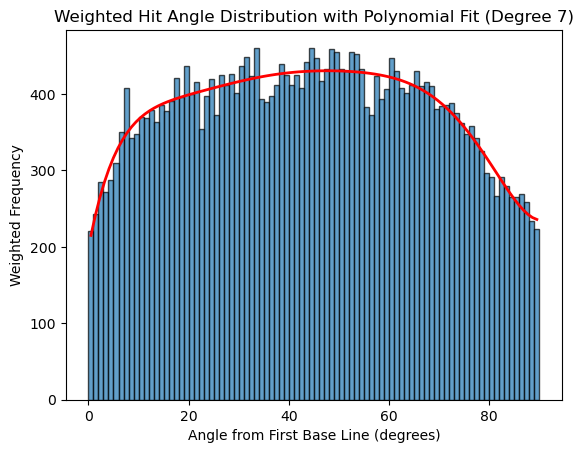

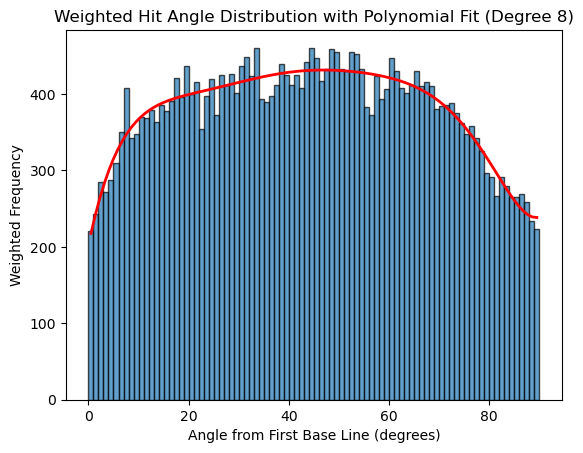

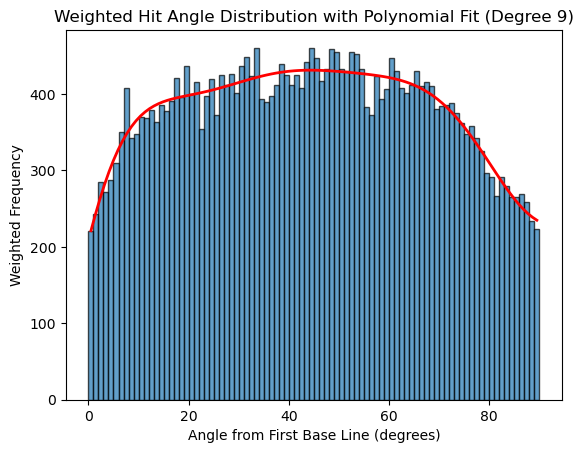

In [57]:
degrees = range(10)
mses = []
for d in degrees:
    _, _, mse = histogram_poly_fit(data, 90, degree=d)
    mses.append(mse)

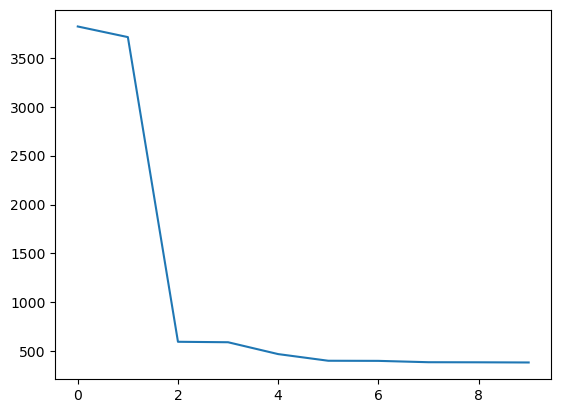

In [58]:
plt.plot(degrees, mses)
plt.show()

In [59]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math

def weighted_histogram_simple_fit(dataframe, num_bins=18, degree=3):
    # Extract 'angle_from_first_base_line' and 'dist' columns from the DataFrame
    angles = dataframe['angle_from_first_base_line']
    distances = dataframe['dist']

    # Min-max scale the 'dist' column to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_distances = scaler.fit_transform(distances.values.reshape(-1, 1))

    # Create a weighted histogram with bins of degree 5 and density=True
    bin_width = math.floor(90 / num_bins)
    bins = list(range(0, 91, bin_width))  # Bins from 0 to 90 with a step of 5
    heights, bins, _ = plt.hist(angles, bins=bins, weights=scaled_distances.flatten(), edgecolor='black', alpha=0.7)

    # Calculate bin centers from bin edges
    bin_centers = (bins[:-1] + bins[1:]) / 2

    lines = plt.plot(bin_centers, heights, 'r', linewidth=2)

    # Set plot labels and title
    plt.xlabel('Angle from First Base Line (degrees)')
    plt.ylabel('Weighted Frequency')
    plt.title(f'Weighted Hit Angle Distribution with Polynomial Fit (Degree {degree})')

    # Show the plot
    plt.show()

    return lines[0]

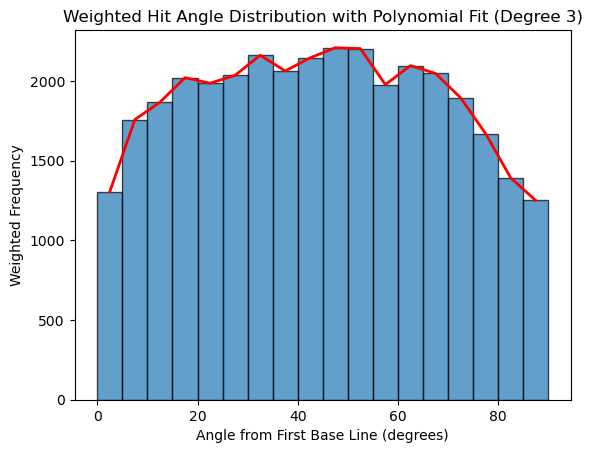

In [60]:
hist_line = weighted_histogram_simple_fit(data)

In [61]:
def get_extrema(poly, x_range):
    # Getting interval critical points
    crit = poly.deriv().r
    r_crit = np.append(crit[crit.imag==0].real, x_range)
    sorted_crit = np.sort(r_crit)
    return sorted_crit, poly(sorted_crit)

In [97]:
def plot_level_set_persistence(y_crit):
    # Convert critical point y-coordinate data into birth and death points
    min_filt = [y_crit[i] < y_crit[i+1] for i in range(len(y_crit)-1)]
    min_filt.append(y_crit[-1] < y_crit[-2])
    y_min = y_crit[min_filt]
    y_max = y_crit[np.invert(min_filt)]

    if len(y_min) == len(y_max):
        y_max = y_max[:-1]
    y_max = np.append(y_max, 1.1 * max(y_crit))

    y_min = sorted(y_min)
    y_max = sorted(y_max)

    plot_min = y_min[0]
    plot_max = y_max[-1]

    points = []
    min_stack = []
    min_idx = 0
    max_idx = 0
    while min_idx < len(y_min) or max_idx < len(y_max):
        if min_idx == len(y_min) or y_min[min_idx] > y_max[max_idx]:
            birth = min_stack.pop()
            points.append((birth, y_max[max_idx]))
            max_idx += 1
        else:
            min_stack.append(y_min[min_idx])
            min_idx += 1

    # Plot the persistence diagram as a scatter plot
    fig, ax = plt.subplots()

    for point in points:
        ax.scatter(point[0], point[1], c='b')

    # Plot the diagonal line y=x
    ax.plot([plot_min, plot_max],
            [plot_min, plot_max],
            '--', color='black')

    ax.axhline(y=plot_max, linestyle='--', color='black')

    # Remove ticks and labels on both axes
    ax.set_xticks([])
    ax.set_yticks([plot_max])
    ax.set_xticklabels([])
    ax.set_yticklabels([r'$\infty$'])
    
    # Set axis labels and title
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.set_title('Persistence Diagram')

    # Show the plot
    plt.show()

In [ ]:
plot_level_set_persistence(hist_line.get_ydata())

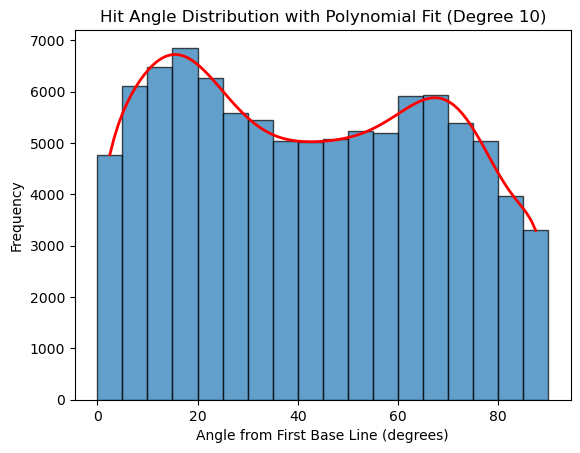

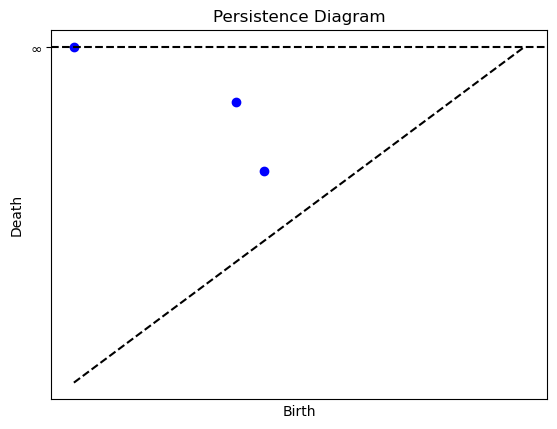

In [98]:
# Polynomial fit on unweighted data
poly_line, poly_range, _ = histogram_poly_fit(data, degree=10, weighted=False)
_, y_crit = get_extrema(poly_line, poly_range)
plot_level_set_persistence(y_crit)

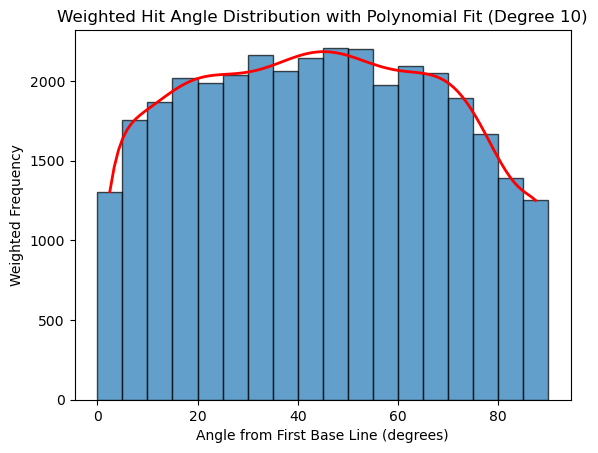

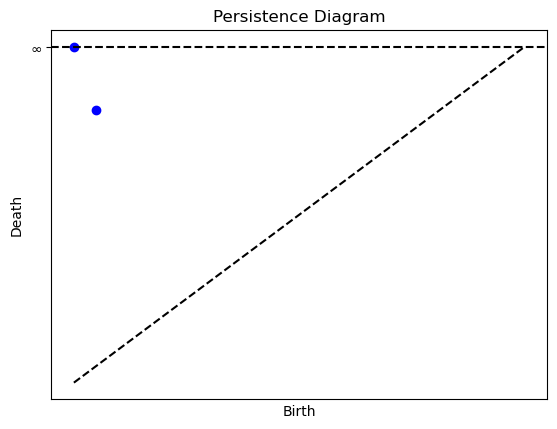

In [65]:
# Polynomial fit on weighted data
poly_line, poly_range, _ = histogram_poly_fit(data, degree=10, weighted=True)
_, y_crit = get_extrema(poly_line, poly_range)
plot_level_set_persistence(y_crit)

In [75]:
data_22 = data[pd.to_datetime(data.date).dt.year == 2022]
data_23 = data[pd.to_datetime(data.date).dt.year == 2023]

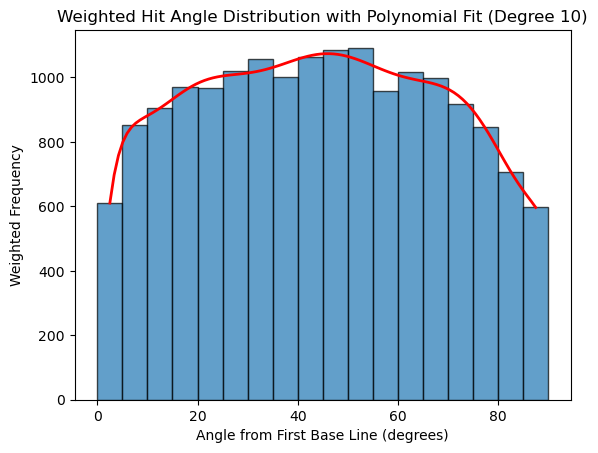

2
2
2


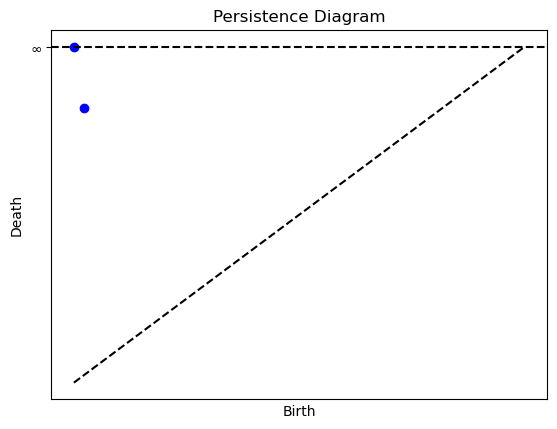

In [94]:
# Polynomial fit on weighted data
poly_line, poly_range, _ = histogram_poly_fit(data_22, degree=10, weighted=True)
_, y_crit = get_extrema(poly_line, poly_range)
plot_level_set_persistence(y_crit)

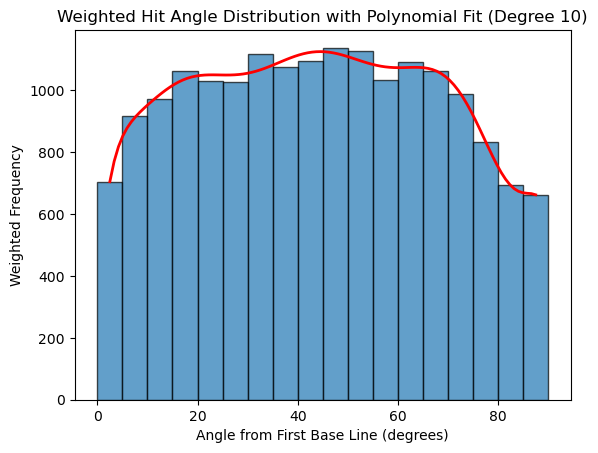

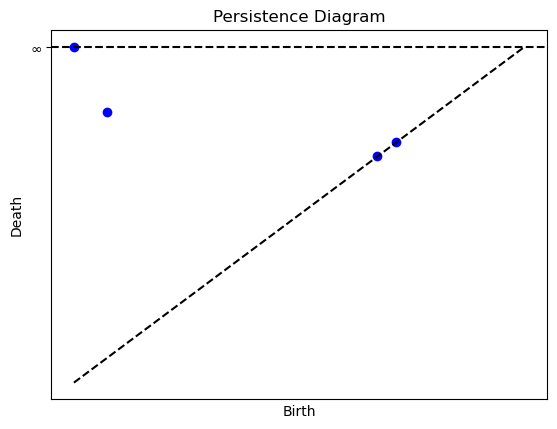

In [99]:
# Polynomial fit on weighted data
poly_line, poly_range, _ = histogram_poly_fit(data_23, degree=10, weighted=True)
_, y_crit = get_extrema(poly_line, poly_range)
plot_level_set_persistence(y_crit)

In [101]:
data_22_L = data_22[data_22.batter_handedness == 'L']
data_23_L = data_23[data_23.batter_handedness == 'L']

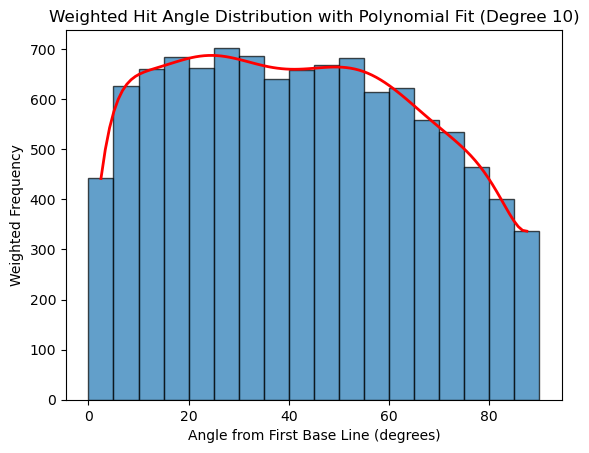

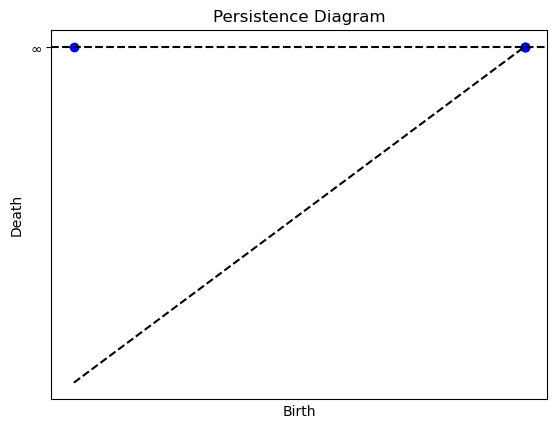

In [104]:
# Polynomial fit on weighted data
poly_line, poly_range, _ = histogram_poly_fit(data_22_L, degree=10, weighted=True)
_, y_crit = get_extrema(poly_line, poly_range)
plot_level_set_persistence(y_crit)

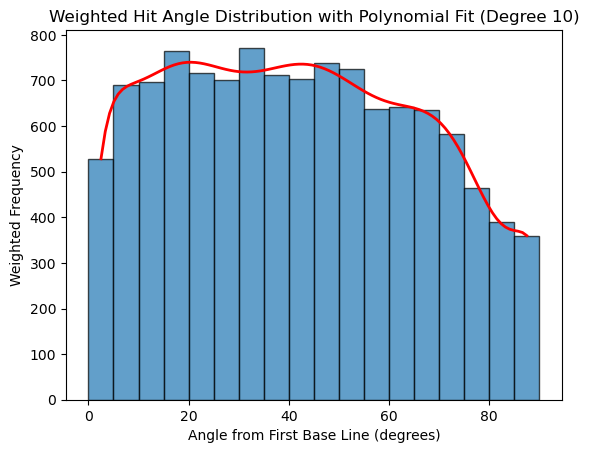

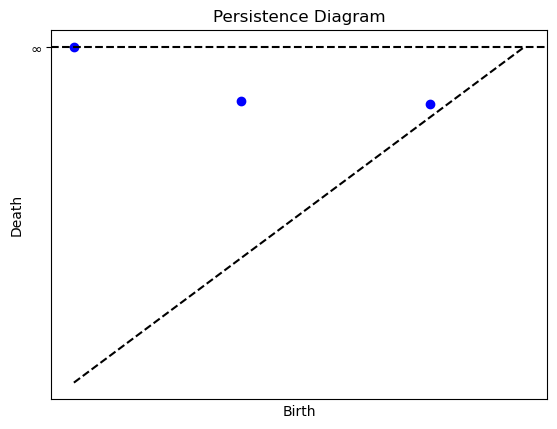

In [103]:
# Polynomial fit on weighted data
poly_line, poly_range, _ = histogram_poly_fit(data_23_L, degree=10, weighted=True)
_, y_crit = get_extrema(poly_line, poly_range)
plot_level_set_persistence(y_crit)

# Old code below

In [66]:
import numpy as np

def interpolate_line(line, num_points=5):
    x_data, y_data = line.get_xdata(), line.get_ydata()

    # Calculate the number of points to add between each existing point
    total_points = (len(x_data) - 1) * (num_points + 1) + 1

    # Use linear interpolation to generate new points
    new_x = np.linspace(x_data[0], x_data[-1], total_points)
    new_y = np.interp(new_x, x_data, y_data)

    # Update the Line2D object with the interpolated points
    line.set_data(new_x, new_y)

    return line

In [67]:
interpolate_line(hist_line)

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams

def level_set_persistance_dgm(line):
    # Get x and y data from line
    x = line.get_xdata()
    y = line.get_ydata()

    # Create a point cloud from the polynomial fit line
    point_cloud = np.column_stack((x, y))

    # Compute persistence diagrams using ripser
    diagrams = ripser(point_cloud)['dgms']

    # Plot the persistence diagram
    plot_diagrams(diagrams, plot_only=[1])
    plt.title('Persistence Diagram')
    plt.show()

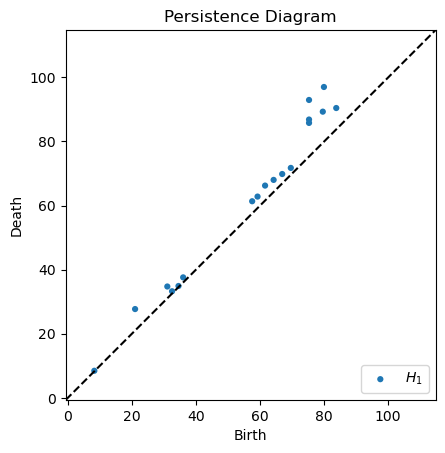

In [69]:
level_set_persistance_dgm(hist_line)

In [70]:
level_set_persistance_dgm(poly_line)

AttributeError: 'poly1d' object has no attribute 'get_xdata'

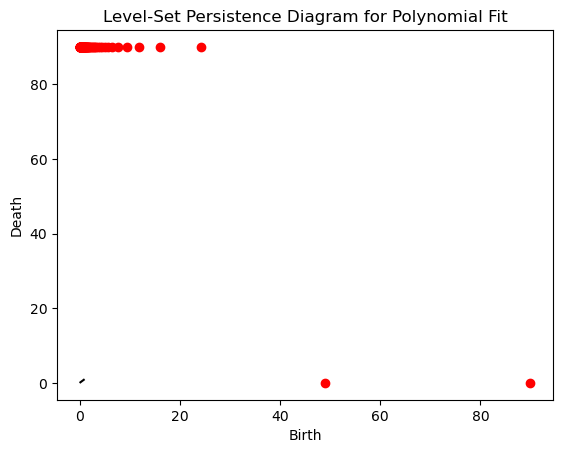

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

def get_polynomial_extrema(coefficients):
    # Function to find local extrema of a polynomial
    def polynomial_function(x):
        return np.polyval(coefficients, x)

    # Find local minima and maxima
    minima = minimize_scalar(polynomial_function, bounds=(0, 90), method='bounded').x
    maxima = minimize_scalar(lambda x: -polynomial_function(x), bounds=(0, 90), method='bounded').x

    return minima, maxima

def plot_level_set_persistence(coefficients):
    # Create a set of thresholds
    thresholds = np.linspace(np.min(coefficients), np.max(coefficients), 100)

    # Lists to store birth and death values for persistence diagram
    births = []
    deaths = []

    print

    for threshold in thresholds:
        # Evaluate the polynomial at the threshold
        polynomial_at_threshold = np.polyval(coefficients, threshold)

        # Get extrema at the current threshold
        minima, maxima = get_polynomial_extrema(coefficients - threshold)

        # Record persistence information
        births.append(minima)
        deaths.append(maxima)

    # Plot persistence diagram
    plt.scatter(births, deaths, c='red', marker='o')
    plt.plot([0, np.max(coefficients)], [0, np.max(coefficients)], 'k--')  # Diagonal line for reference
    plt.xlabel('Birth')
    plt.ylabel('Death')
    plt.title('Level-Set Persistence Diagram for Polynomial Fit')

    # Show the plot
    plt.show()

# Example usage:
# Assuming your polynomial coefficients are in the variable 'coefficients'
# Replace this with the actual coefficients from your polynomial fit
coefficients = np.array([1, -2, 1])  # Example quadratic polynomial coefficients
plot_level_set_persistence(coefficients)


In [ ]:
print(get_polynomial_extrema(coefficients))

(1.0, 89.99999324866232)
